In [ ]:
# default_exp tree

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import re
import IPython, graphviz

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import export_graphviz

from oae.core import *

SEED = 41
np.random.seed(SEED)

In [ ]:
#export
_all_ = ['ATMSKLEARN', 'Instance']

# Representation

> How to represent a trained additive tree model?

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [ ]:
Xtr, Xte, ytr, yte = get_example_dataset()

In [ ]:
clf = RandomForestClassifier(n_estimators=5, max_depth=3, random_state=SEED, n_jobs=-1)
clf.fit(Xtr, ytr)

RandomForestClassifier(max_depth=3, n_estimators=5, n_jobs=-1, random_state=41)

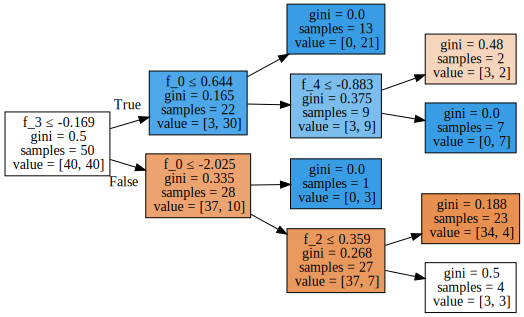

In [ ]:
df_trn = pd.DataFrame(Xtr, columns=[f'f_{i}' for i in range(5)])
draw_tree(clf.estimators_[0], df_trn, precision=3)

In [ ]:
#export
class ATMSKLEARN:
    def __init__(self, trained_model):
        self.trained_model = trained_model
        
        self.check_tree_with_no_leaves()
        
    def check_tree_with_no_leaves(self):
        for tidx, t in enumerate(self.get_trees()):
            if len(t.tree_.feature) < 0: raise ValueError(f'Tree: {tidx} has no leaves.')
        
    def get_trees(self):
        return self.trained_model.estimators_
    
    @property
    def num_trees(self):
        return len(self.get_trees())
    
    def calculate_tree_weights(self):
        T = self.num_trees
        return np.ones(shape=(T, )) / T
    
    def get_leaves(self, tree):
        return np.where(tree.feature < 0)[0]
    
    def get_leaves_value(self, tree, leaves):
        return np.array([tree.value[l] for l in leaves])
    
    def get_node_threshold(self, tree, fidx):
        idx = np.where(tree.feature == fidx)[0]
        return list(tree.threshold[idx]) if len(idx) > 0 else []
    
    def make_partitions(self, splits, INF=1e8):
        splits = np.insert(splits, 0, -INF)
        splits = np.insert(splits, len(splits), INF)

        partitions = []
        for i in range(len(splits) - 1):
            partitions.append([splits[i], splits[i+1]])

        return partitions
    
    def h_k(self, tree, combine, class_):
        leaves = self.get_leaves(tree)
        leaves_value = self.get_leaves_value(tree, leaves)
        return combine(leaves_value, class_)
    
    def h_t_k(self, combine, class_=None):
        return [self.h_k(tree.tree_, combine, class_) for tree in self.get_trees()]
    
    def phi_k(self, tree, x):
        leaves = self.get_leaves(tree)
        return [tree.decision_path(x.astype(np.float32)).toarray().ravel()[leaf] for leaf in leaves]
    
    def phi_t_k(self, x):
        return [self.phi_k(tree.tree_, x) for tree in self.get_trees()]
    
    def feature_partitions_cat(self, fidx):
        return np.hstack(sorted([self.get_node_threshold(tree.tree_, fidx) for tree in self.get_trees()])).reshape(-1, 1)
    
    def feature_partitions_num(self, fidx):
        splits = np.hstack([self.get_node_threshold(tree.tree_, fidx) for tree in self.get_trees()])
        splits = np.sort(splits)
        return self.make_partitions(splits)
    
    def v_j(self, fidx, ftype):
        if ftype == 'categorical': return self.feature_partitions_cat(fidx)
        else: return self.feature_partitions_num(fidx)
        
    def v_i_j(self, feature):
        fdtypes = feature.dtypes
        feat    = feature.content
        return [self.v_j(i, fdtypes[i]) for i in range(len(fdtypes))]
    
    def v_j_mask(self, partition, fval):
        return [1 if fval >= s[0] and fval < s[len(s) - 1] else 0 for s in partition]
    
    def v_i_j_mask(self, partitions, feature):
        return [self.v_j_mask(partitions[i], feature.content[i]) for i in range(len(partitions))]
    
    def mask_v_j(self, mask, partition):
        return [partition[midx] for midx, m in enumerate(mask) if m]
    
    def masks_v_i_j(self, masks, partitions):
        return [self.mask_v_j(masks[i], partitions[i]) for i in range(len(partitions))]
    
    
    def suggest_changes(self, sol_mask, feature):
        partitions = self.v_i_j(feature)
        orig_mask  = self.v_i_j_mask(partitions, feature)
        
        changes = []
        for i in range(len(sol_mask)):
            if sol_mask[i] == orig_mask[i]:
                changes.append(f'no change, current value: {feature.content[i]}')
            else:
                sol_mask_one_idx  = np.where(np.array(sol_mask[i]) == 1)[0][0]
                changes.append(f'current value: {feature.content[i]}, proposed range: {partitions[i][sol_mask_one_idx]}')
        
        return changes
    
    def transform(self, sol_mask, feature):
        partitions = self.v_i_j(feature)
        orig_mask  = self.v_i_j_mask(partitions, feature)
        
        fnames = feature.fnames
        
        transformed_feature = []
        for i in range(len(sol_mask)):
            if sol_mask[i] == orig_mask[i]:
                transformed_feature.append(feature.content[i])
            else:
                sol_mask_one_idx  = np.where(np.array(sol_mask[i]) == 1)[0][0]
                if len(partitions[i][sol_mask_one_idx]) > 1:
                    transformed_feature.append(np.random.uniform(partitions[i][sol_mask_one_idx][0],
                                                                 partitions[i][sol_mask_one_idx][1]
                                                                ))
                else:
                    transformed_feature.append(partitions[i][sol_mask_one_idx][0])
                    
        return pd.DataFrame(np.array(transformed_feature).reshape(1, -1), columns=fnames)
        
    def find_ancestors(self, tree, node, leaf_node, p):
        if node == leaf_node: return [True, p]
        if tree.feature[node] < 0: 
            p.pop()
            return [False, p]

        in_left_branch, p = (self.find_ancestors(tree, tree.children_left[node], leaf_node, p + [(node, 'left')]))
        if in_left_branch: return [True, p]

        in_right_branch, p = (self.find_ancestors(tree, tree.children_right[node], leaf_node, p + [(node, 'right')]))
        if in_right_branch: return [True, p]

        p.pop()
        return [False, p]
    
    def pi_k(self, tree):
        leaves = self.get_leaves(tree)
        root_index = 0
        return {kidx:self.find_ancestors(tree, node=root_index, leaf_node=k, p=[])[1] for kidx, k in enumerate(leaves)}
        
    def pi_t_k(self):
        trees = self.get_trees()
        return [self.pi_k(tree.tree_) for tree in trees]
    
    def predicate_mask(self, tree, fname, fidx, branch, v_i_j):
        threshold = tree.threshold[fidx]

        if branch == 'left': return [1 if p[1] < threshold else 0 for p in v_i_j[fname]] 
        else: return [1 if p[0] >= threshold else 0 for p in v_i_j[fname]]

    def predicates_mask(self, tree, ancestor, v_i_j):
        p, p_branch = ancestor
        fname = tree.feature[p]
        return self.predicate_mask(tree, fname, p, p_branch, v_i_j)

In [ ]:
#export
def combine(leaves_value, class_):
    if class_ is None: class_ = 1
    return [(c.ravel() / c.ravel().sum())[class_] for c in leaves_value]

In [ ]:
atm = ATMSKLEARN(clf)

assert atm.num_trees == 5
assert all(atm.calculate_tree_weights() == np.array([1/5] * 5))
assert all(atm.get_leaves(clf.estimators_[0].tree_) == [2, 4, 5, 7, 9, 10])

def combine(leaves_value, class_):
    if class_ is None: class_ = 1
    return [(c.ravel() / c.ravel().sum())[class_] for c in leaves_value]

assert atm.h_k(clf.estimators_[0].tree_, combine, class_=1) == [1.0, 0.4, 1.0, 1.0, 0.10526315789473684, 0.5]

For each leaf node $k = 1,. . ., m_t$, we use a binary variable $\phi_{t,k}$ ∈ {0, 1} to denote whether a given instance x reaches it. Due to the property of the tree structure, each instance reaches exactly one leaf node.

$$\sum_{k=1}^{m_t} \phi_{t,k} = 1  $$for t = 1,...,T

For a particular instance `Xte[4]` the following matrix represents in which leaf node would this instance reach. e.g:
for tree-0 this instance would reach 0th leaf, for tree-1 this instance would also reach 0th leaf and so on.

In [ ]:
atm.phi_t_k(Xte[4:5])

[[1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 0]]

This test is to check whether an instance reaches exactly one leaf one in all trees or not.

In [ ]:
assert all([sum(r) == 1 for r in atm.phi_t_k(Xte[4:5])])

This way, $f_{t}(x)$ can be expressed as:
$f_{t}(x) = \sum_{k=1}^{m_t} h_{t,k}\phi_{t,k}$, where $h_{t_k} \in R$

In case of classification, we look at the class distribution of leaves and report average as $h_{t,k}$ for k-th leaf node of t-th tree

In [ ]:
atm.h_t_k(combine)

[[1.0, 0.4, 1.0, 1.0, 0.10526315789473684, 0.5],
 [1.0, 0.0, 0.8571428571428571, 1.0, 0.07317073170731707, 1.0],
 [0.0, 1.0, 0.0, 0.75, 0.75, 1.0, 1.0, 0.16666666666666666],
 [1.0, 0.8333333333333334, 1.0, 0.13953488372093023, 0.7142857142857143],
 [0.0, 0.9375, 1.0, 0.0, 0.16, 1.0]]

In [ ]:
h_t_k   = atm.h_t_k(combine)
phi_t_k = atm.phi_t_k(Xte[4:5]) 
w_t     = atm.calculate_tree_weights()

In [ ]:
clf.predict_proba(Xte[4:5])

array([[0.04583333, 0.95416667]])

The following test is to verify that $f_{t}(x) = \frac{1}{w_{t}} \sum_{k=1}^{m_t} h_{t,k}\phi_{t,k}$, where $h_{t_k} \in R$ is equal to `clf.predict_proba(x)[1]` or not, assuming `1` is the class of interest.

In [ ]:
tolerance = 1e-6
assert np.abs(np.sum([h_t_k[i][j] * phi_t_k[i][j] * w_t[i] for i in range(len(h_t_k)) for j in range(len(h_t_k[i]))])\
              - 0.9541667) < tolerance

In [ ]:
#export
class Instance:
    def __init__(self, x, dtypes):
        if len(dtypes) == 0: raise ValueError('Data type list cannot be empty')
        
        if isinstance(x, pd.Series): self.content = self.x.values
        else: self.content = np.array(x)
        
        if isinstance(x, pd.Series): self.feat_names = x.columns.tolist()
        else: self.feat_names = [f'f_{i}' for i in range(len(x))]
        
        self.types = dtypes
    
    @property
    def value(self): return self.content
    @property
    def dtypes(self): return self.types
    @property
    def fnames(self): return self.feat_names

Given an additive tree model, each feature $x_i, i = 1,..., D$, is split into a
number of partitions.
- If $x_i$ is categorical with n categories, then xi naturally has n partitions.
- If $x_i$ is numerical, we assume each tree node branches in the form of $x_i \geq b$ where $b \in R$ is a splitting point.

If there are n splitting points for $x_i$ in all the trees in the additive tree model, the feature $x_i$ is naturally split into n + 1 partitions. In the following, let $n_i$ be the number of partitions for feature $x_i$.

Feature value variables. Given an instance x, we use a binary variable $v_{i,j} \in \{0, 1\}$ to denote whether $x_i$ is in the jth partition of dimension i. $v_{i,j} = 1$ if and only if $x_i$ is in the jth partition.

Since an instance could only reside in exactly one partition for each feature, we know that $v_{i,j}$ should satisfy

$$\sum_{j=1}^{n_i} v_{i,j} = 1$$

In [ ]:
atm = ATMSKLEARN(clf)

partitions = np.array([[-1e8, -1.7815466523170471],
             [-1.7815466523170471, -1.470717191696167],
             [-1.470717191696167, -1.0116309821605682],
             [-1.0116309821605682, -0.5423658043146133],
             [-0.5423658043146133, -0.531291589140892],
             [-0.531291589140892, 2.3792918920516968],
             [2.3792918920516968, 1e8]])

assert all((atm.v_j(fidx=1, ftype='numerical') == partitions).ravel())

In [ ]:
instance = Instance(Xte[4], ['numerical'] * 5)
instance.fnames

['f_0', 'f_1', 'f_2', 'f_3', 'f_4']

In [ ]:
instance.dtypes

['numerical', 'numerical', 'numerical', 'numerical', 'numerical']

`atm.v_i_j(instance)` lists down all the partitions based on feature type for a particular instance

In [ ]:
atm.v_i_j(instance)

[[[-100000000.0, -2.0248294472694397],
  [-2.0248294472694397, 0.6338021159172058],
  [0.6338021159172058, 0.6439935863018036],
  [0.6439935863018036, 0.6447310447692871],
  [0.6447310447692871, 0.836201936006546],
  [0.836201936006546, 0.8496142029762268],
  [0.8496142029762268, 100000000.0]],
 [[-100000000.0, -1.7815466523170471],
  [-1.7815466523170471, -1.470717191696167],
  [-1.470717191696167, -1.0116309821605682],
  [-1.0116309821605682, -0.5423658043146133],
  [-0.5423658043146133, -0.531291589140892],
  [-0.531291589140892, 2.3792918920516968],
  [2.3792918920516968, 100000000.0]],
 [[-100000000.0, -0.5003760457038879],
  [-0.5003760457038879, 0.10728693753480911],
  [0.10728693753480911, 0.2221900150179863],
  [0.2221900150179863, 0.2427385449409485],
  [0.2427385449409485, 0.3585205078125],
  [0.3585205078125, 0.6139787286520004],
  [0.6139787286520004, 0.6645539551973343],
  [0.6645539551973343, 100000000.0]],
 [[-100000000.0, -0.16905810683965683],
  [-0.16905810683965683,

In [ ]:
atm = ATMSKLEARN(clf)

partitions = atm.v_i_j(instance)
v_i_j_mask = atm.v_i_j_mask(partitions, instance)

assert all([np.sum(x) == 1 for x in v_i_j_mask])

Given a leaf node $k$ in tree $t$, suppose $\pi_{t,k}$ is the set of all its ancestor nodes in the tree.

In [ ]:
atm = ATMSKLEARN(clf)

pi_t_k  = atm.pi_t_k()

assert pi_t_k[0][0] == [(0, 'left'), (1, 'left')]
assert pi_t_k[0][3] == [(0, 'right'), (6, 'left')]

`atm.predicates_mask(tree, pi_t_k[t][k][p], partitions)` represents $s_{k,p}$, where

For any node $p \in \pi_{t,k}$, suppose $p$ branches on feature $i$, we define $S_{k,p}$ to be the set containing all predicates $v_{i,j}$ satisfying that $v_{i,j}$ = 1 leads to the branch towards leaf node $k$.

In [ ]:
atm = ATMSKLEARN(clf)

h_t_k   = atm.h_t_k(combine)
phi_t_k = atm.phi_t_k(Xte[4:5]) 
w_t     = atm.calculate_tree_weights()


instance   = Instance(Xte[4], ['numerical'] * 5)
partitions = atm.v_i_j(instance)
v_i_j_mask = atm.v_i_j_mask(partitions, instance)

pi_t_k  = atm.pi_t_k()

atm.predicates_mask(clf.estimators_[0].tree_, pi_t_k[0][0][1], partitions)

[1, 1, 0, 0, 0, 0, 0]

In [ ]:
s_t_k_p = [[[atm.predicates_mask(t.tree_, a, partitions) for a in pi_t_k[tidx][kidx]]\
           for kidx, k in enumerate(atm.get_leaves(t.tree_))] \
           for tidx, t in enumerate(clf.estimators_)]

Making use of the tree structure, we have the following properties:
- If $\phi_{t,k} = 1$, meaning that the instance x lies in the leaf node k in tree t, then there is always one of the predicates $v_{i,j}$ in $S_{k,p}$ being 1 for any node $p \in \pi_{t,k}$.
- If $\phi_{t,k} = 0$, then there exists at least one node p such that all the predicates in $S_{k,p}$ are 0.

Combining above two, we get

$$\phi_{t, k} \leq \frac {1}{\mid {\pi_{t,k}}\mid} \sum_{p \in \pi_{t,k}}\sum_{v \in s_{k,p}} v, \forall t,k$$

In [ ]:
trees = atm.get_trees()

for i in range(len(trees)):
    for j in range(len(atm.get_leaves(trees[i].tree_))):
        res = 0
        nancestors = len(pi_t_k[i][j])
        for predicate in s_t_k_p[i][j]:
            res += np.sum(predicate)
        
        if phi_t_k[i][j] > (res / nancestors):
            raise AssertionError('Decision Logic constraint violated')

## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_Representation.ipynb.
Converted 02_Optimizer.ipynb.
Converted index.ipynb.
